In [3]:
import numpy as np
import matplotlib.pyplot as plt
import Basemap

ImportError: No module named Basemap

In [2]:
from mpl_toolkits.basemap import Basemap

ImportError: No module named basemap

In [4]:
from obspy import read_inventory, read_events

/Users/msmiller/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


In [23]:
from bs4 import BeautifulSoup
import urllib

In [26]:
def build_query(outFormat = 'text', starttime = '2016-02-01', endtime = '2016-03-01', minmagnitude = 5.0):
    '''
    Funciton to build the url for query the data. Details can be found at USGS api documentation:
    http://earthquake.usgs.gov/fdsnws/event/1/
    
    Note: you can add more parameters, but I just need time range and minmum magnitude to start with. 
    '''
    base = 'http://earthquake.usgs.gov/fdsnws/event/1/query?'
    url = base + 'format=' + outFormat + '&starttime=' + starttime + '&endtime=' + endtime + '&minmagnitude=' + str(minmagnitude)
    return url

def parse_result(inputText):
    '''
    Function to parse the requested earthquake events data from USGS, and save it into numpy array
    '''
    event_id = []
    origin_time = []
    evla = []
    evlo = []
    evdp = []
    mag = []
    mag_type = []
    EventLocationName  = []
    for i, item in enumerate(inputText.split('\n')[0:-1]):
        if i < 1:
            # skip the header
            continue
            
        try:
            splited = item.split('|')
            event_id.append(splited[0])  
            origin_time.append(splited[1])
            evla.append(splited[2])
            evlo.append(splited[3])
            evdp.append(splited[4])
            mag.append(splited[10])
            mag_type.append(splited[9])
            EventLocationName.append(splited[-1])
        except:
            # just in case there are some wrong data in the catlog
            print item
            print 'Skip wrong data or there is something wrong' 
        
    return np.c_[event_id, origin_time, evla, evlo, mag, mag_type, EventLocationName]

In [27]:
# let's get the earthquake larger than M5 globally from 2010-01-01 to 2016-01-01. 
url = build_query(outFormat = 'text', starttime = '2010-01-01', endtime = '2016-01-01', minmagnitude = 5.0)
print url

http://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2010-01-01&endtime=2016-01-01&minmagnitude=5.0


In [28]:
# get the earthquake data from USGS and parse them into a numpy array
r = urllib.urlopen(url).read()
soup = BeautifulSoup(r, "lxml")
events_mat = parse_result(soup.text)

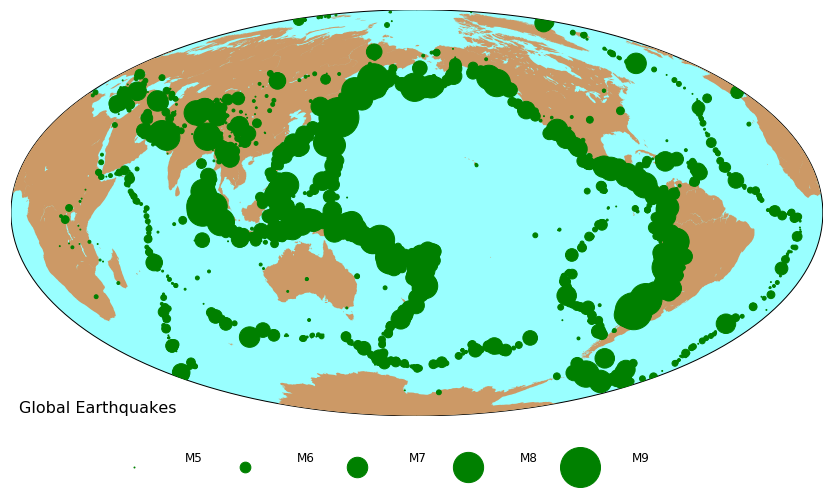

In [58]:
fig = plt.figure(figsize = (12,9))
map_ax = fig.add_axes([0.03, 0.13, 0.94, 0.82])

map = Basemap(projection='hammer',lon_0=180, resolution = 'l')

map.drawmapboundary(fill_color='#99ffff')
map.fillcontinents(color='#cc9966',lake_color='#99ffff')
    
################plot earthquakes###############
# get the latitude, longitude, and magnitude for plotting
lats = [float(item[2]) for item in events_mat]
lons = [float(item[3]) for item in events_mat]
mags = [float(item[4]) for item in events_mat]
x, y = map(lons, lats)

#scale the size of the earthquake on the map
min_size = 50
max_size = 90
min_mag = min(mags)
max_mag = max(mags)

frac = [(_i - min_mag) / (max_mag - min_mag) for _i in mags]
magnitude_size = [(_i * (max_size - min_size)) **2 for _i in frac]
map.scatter(x, y, marker='o', s=magnitude_size, c='g',zorder=10)


#######plot scale, annotation, and legend#######
plt.annotate('Global Earthquakes', xy=(0.01, 0.01), xycoords='axes fraction', fontsize = 16)
legends = []
for mag_ in [5., 6., 7., 8., 9.]:
    frac = (mag_ - min_mag + 0.1) / (max_mag - min_mag)
    magnitude_size = (frac * (max_size - min_size)) **2
    l1 = plt.scatter([], [], marker='o', s=magnitude_size, c='green', zorder=10)
    legends.append(l1)
    
ll = ['M5\n', 'M6\n', 'M7\n', 'M8\n', 'M9\n']

leg = plt.legend(legends, ll, scatterpoints = 1, ncol=6, frameon=False, fontsize=12, handlelength=7, \
    columnspacing = 0.01, bbox_to_anchor=(0.8, -0.06))   

plt.show()

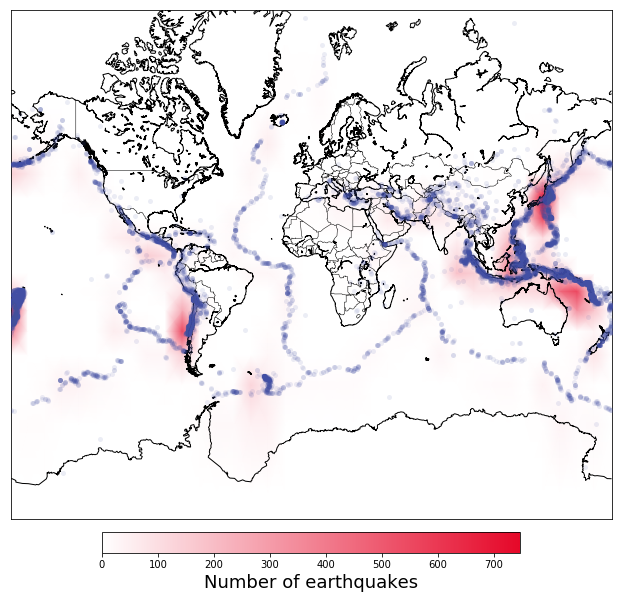

In [32]:
from matplotlib.colors import LinearSegmentedColormap

m = Basemap(projection='merc',llcrnrlat=-82,urcrnrlat=82,\
            llcrnrlon=-180,urcrnrlon=180, resolution = 'l')
m.drawcoastlines()
m.drawcountries()

# compute appropriate bins to aggregate data
# nx is number of bins in x-axis, i.e. longitude
# ny is number of bins in y-axis, i.e. latitude
nx = 36 # 10 degree for longitude bin
ny = 18 # 10 degree for latitude bin

# form the bins
lon_bins = np.linspace(-180, 180, nx)
lat_bins = np.linspace(-90, 90, ny)
    
# aggregate the number of earthquakes in each bin, we will only use the density
density, lat_edges, lon_edges = np.histogram2d(lats, lons, [lat_bins, lon_bins])

# get the mesh for the lat and lon
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the bin mesh to map coordinates:
xs, ys = m(lon_bins_2d, lat_bins_2d) # will be plotted using pcolormesh

# define custom colormap, white -> red, #E6072A = RGB(0.9,0.03,0.16)
cdict = {'red':  ( (0.0,  1.0,  1.0),
                   (1.0,  0.9,  1.0) ),
         'green':( (0.0,  1.0,  1.0),
                   (1.0,  0.03, 0.0) ),
         'blue': ( (0.0,  1.0,  1.0),
                   (1.0,  0.16, 0.0) ) }
custom_map = LinearSegmentedColormap('custom_map', cdict)
plt.register_cmap(cmap=custom_map)

# Here adding one row and column at the end of the matrix, so that 
# density has same dimension as xs, ys, otherwise, using shading='gouraud'
# will raise error
density = np.hstack((density,np.zeros((density.shape[0],1))))
density = np.vstack((density,np.zeros((density.shape[1]))))

# Plot heatmap with the custom color map
plt.pcolormesh(xs, ys, density, cmap="custom_map", shading='gouraud')

# Add color bar and 
cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
cbar.set_label('Number of earthquakes',size=18)

# Plot blue scatter plot of epicenters above the heatmap:    
x,y = m(lons, lats)
m.plot(x, y, 'o', markersize=5,zorder=6, markerfacecolor='#424FA4',markeredgecolor="none", alpha=0.1)

# make image bigger:
plt.gcf().set_size_inches(12,12)

plt.show()